<h1>The objective of the program is to categorize books according to their cover.</h1>

# Dataset
We used a dataset available at this address :
https://github.com/uchidalab/book-dataset<br>
3 data sets were available :<br>
Data set Train ==> 51 300 images<br>
Data set test ==> 5 700 images<br>

# Classification
We used 3 models to classify covers :<br>

    --> 2 from inceptionV3 CNN model
    --> 1 Text mining model

<h4> INCEPTION</h4>
Inception network is very powerful, we changed the last layer and replace it with 3 layers (Two dense layers and one Dropout). We tried many modifications
but it appears that overfitting was very difficult to limit due to the high
covers variablity. We choose to re-train the last 100 layers of the new
inception model. The others were pre-trained with imageNet data.
After training, we also used inception in a different way. We choose to
extract features from the last GlobalAveragePooling2D layer. These 2048
features were reducted to 229 (keeping 90% of variablity) thanks to PCA.

Finally, we used SVM to elaborate a new classification model.<br>

    --> Inception (classical re-trained inception with our added layers)
    --> SVM_inception (Extracted features from our retrained inception model)

# TEXT MINING
Text mining's goal is to extract text from each image of the datasets,
and then classify covers with the extracted text.
Once the text extracted, we do some transformation on it.
We retrieve the words from text which do not contain information (with stop_words)
and then we use only the stemming part of each word left (with EnglishStemmer).
And once our text transformation done, we use a MultinomialNB classifier for the prediction.<br>

    --> TextMining model



In [5]:
work_dir='C:/Users/Rajasree/Code/Final-Year-Project/Book_project/pre_trained_models/'

# Packages

In [2]:
import os
import csv
import keras
import nltk
import pickle
import itertools
import cv2 as cv
#%matplotlib inline
import pytesseract
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from joblib import load, dump
import matplotlib.pylab as plt
from IPython.display import clear_output, Image as Im, display

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import EnglishStemmer
#nltk.download('punkt')
#nltk.download('stopwords')

from bokeh.plotting import figure
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import push_notebook,output_notebook, show
output_notebook()

from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from keras import callbacks
from keras.preprocessing import image
from keras.optimizers import Adam ,SGD
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, GlobalAveragePooling2D
from keras.models import Sequential, Model, load_model, model_from_json
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import string
import re
# To use pytesseract with Windows OS (Filepath to tesseract-data)
pytesseract.pytesseract.tesseract_cmd=r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# To use pytesseract with Mac OS type the command pip install pytesseract on your terminal

Using TensorFlow backend.
C:\Users\Rajasree\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rajasree\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Rajasree\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Rajasree\Anaconda3\lib\site-packages\tensorflow\python\framewo

Loading BokehJS ...

C:\Users\Rajasree\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# import tensorflow as tf
# tf.test.is_gpu_available()

# Pre-trained model loading


In [6]:
if os.path.isfile(work_dir + 'new_inception.json') == True and \
   os.path.isfile(work_dir + 'new_inception.h5') == True:

    print("New_inception model loading...")
    json_file = open(work_dir + "new_inception.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    new_inception = model_from_json(loaded_model_json)
    new_inception.load_weights(work_dir + "new_inception.h5")
    print("New_inception model loaded")
else:
    print("New_inception model can not be loaded, please check the file name or the filepath")


if os.path.isfile(work_dir + 'SVM_new_inception') == True and \
   os.path.isfile(work_dir + 'pca_pre_SVM') == True:
    print('SVM_new_inception model loading...')
    pca_pre_svm = load(work_dir + 'pca_pre_SVM')
    clf_SVM_new_inception = load(work_dir + 'SVM_new_inception')
    print("SVM_new_inception model loaded")
else:
    print("SVM_New_inception model can not be loaded, please check the file name or the filepath")


if os.path.isfile(work_dir + 'clf_textmining') == True and \
   os.path.isfile(work_dir + 'stopwords') == True and \
   os.path.isfile(work_dir + 'countvectorizer') == True and \
   os.path.isfile(work_dir + 'tfidf_transformer') == True:
    print('Text Mining model loading...')

    stop_words=load(work_dir + "stopwords")
    countv=load(work_dir + "countvectorizer")
    tformer=joblib.load(work_dir + "tfidf_transformer")
    clf_TextMining=joblib.load(work_dir + "clf_textmining")

    print("Text Mining model loaded")
else:
    print("Text Mining model can not be loaded, please check the file name or the filepath")

Choice_matrix=pd.read_csv(work_dir + "Choice_matrix.csv", sep=";",index_col=0)
Choice_matrix_img=pd.read_csv(work_dir + 'Choice_matrix_img.csv', sep=";",index_col=0)

W0225 16:05:44.325856 10220 deprecation_wrapper.py:119] From C:\Users\Rajasree\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



New_inception model loading...


W0225 16:05:45.242801 10220 deprecation_wrapper.py:119] From C:\Users\Rajasree\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0225 16:05:45.380383 10220 deprecation_wrapper.py:119] From C:\Users\Rajasree\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0225 16:05:45.382378 10220 deprecation_wrapper.py:119] From C:\Users\Rajasree\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0225 16:05:45.384410 10220 deprecation_wrapper.py:119] From C:\Users\Rajasree\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0225 16:05:45.981446 10220 deprecation_wra

New_inception model loaded
SVM_new_inception model loading...


C:\Users\Rajasree\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Rajasree\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


SVM_new_inception model loaded
Text Mining model loading...


C:\Users\Rajasree\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Rajasree\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Rajasree\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Text Mining model loaded


# VARIABLES
2 data sets were available :

Data set Train ==> 51 300 images<br>
Data set test ==> 5 700 images<br>

In [7]:
#Loading of dataframe train and test.
df_train = pd.read_csv(work_dir+"book30-listing-train.csv",engine = "python", header = None)
df_test = pd.read_csv(work_dir+"book30-listing-test.csv",engine = "python", header = None)
df_list = pd.read_csv(work_dir+"book32-listing.csv",engine = "python", header = None)

Col_names=["Amazon_index","Filename","Image_url","Title","Author","Category_id","Category"]
df_train.columns=Col_names
df_test.columns=Col_names
df_list.columns=Col_names

## Filepath of database Train and test
train_path = work_dir+'Database_train'
test_path = work_dir+'Database_test'
list_path=work_dir+"BigData"
## Adding filepath column to dataframes
filepath=list()
for i in range(len(df_test.Filename)):
    filepath.append(test_path+"/"+df_test.Category[i]+"/"+df_test.Filename[i])
df_test["Filepath"]=filepath

filepath=list()
for i in range(len(df_train.Filename)):
    filepath.append(train_path+"/"+df_train.Category[i]+"/"+df_train.Filename[i])
df_train["Filepath"]=filepath

filepath=list()
for i in range(len(df_list.Filename)):
    filepath.append(list_path+"/"+df_list.Category[i]+"/"+df_list.Filename[i])
df_list["Filepath"]=filepath

## storage of category names
cat = pd.DataFrame(df_train['Category'].value_counts())
classe=['Arts & Photography',
 'Biographies & Memoirs',
 'Business & Money',
 'Calendars',
 "Children's Books",
 'Comics & Graphic Novels',
 'Computers & Technology',
 'Cookbooks, Food & Wine',
 'Crafts, Hobbies & Home',
 'Christian Books & Bibles',
 'Engineering & Transportation',
 'Health, Fitness & Dieting',
 'History',
 'Humor & Entertainment',
 'Law',
 'Literature & Fiction',
 'Medical Books',
 'Mystery, Thriller & Suspense',
 'Parenting & Relationships',
 'Politics & Social Sciences',
 'Reference',
 'Religion & Spirituality',
 'Romance',
 'Science & Math',
 'Science Fiction & Fantasy',
 'Self-Help',
 'Sports & Outdoors',
 'Teen & Young Adult',
 'Test Preparation',
 'Travel']             

In [8]:
# pd.reset_option('max_colwidth')

In [9]:
# pd.set_option('display.max_colwidth', -1)

In [10]:
# df_test.Filepath

# Functions
### LeNet Model

In [11]:
def LeNet_model(df_train=df_train, df_test=df_test):

    # Create input array for CNN learning
    def generate_image_data(images,size=28):
       tensor=list()

    # images = list of all images filepath ex: test_data.path
    # size = int, wanted picture size

       for i in range(len(images)):
    # Image reading
           img=plt.imread(images[i])
    # Image resizing
           resized=cv2.resize(img,dsize=(size,size),interpolation=cv2.INTER_CUBIC)
    # Detecting whether image is in greyscale
           if(len(resized.shape)==2):
               resized=grey2rgb(resized)
    # Detecting whether image is in rgba
           if(resized.shape[2]==4):
               resized=(rgba2rgb(resized)*255).astype("int")
    # Adding resized image to the list
           tensor.append(resized)
    # Transforming list of images into a single array
       tensor=np.asarray(tensor)
       return tensor


    # Generating Train/Test datasets
    Xtest=generate_image_data(df_test.Filepath,size=28)
    Xtrain=generate_image_data(df_train.Filepath,size=28)
    ytrain=df_train.Category_id
    ytest=df_test.Category_id

    ytest=np_utils.to_categorical(df_test.Category_id)
    ytrain=np_utils.to_categorical(df_train.Category_id)


    ###LeNet model
    model = Sequential()
    model.add(Conv2D(filters=30, kernel_size=(5,5), border_mode='valid', input_shape=(28,28,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model = Sequential()
    model.add(Conv2D(filters=30, kernel_size=(5,5), border_mode='valid', input_shape=(28,28,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(filters=15, kernel_size=(3,3), border_mode='valid', input_shape=(28,28,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dense(40, activation='relu'))
    model.add(Dense(30, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



    #model training
    model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest),epochs=50, batch_size=300, verbose=1,shuffle=True)

    #prediction
    test_pred = model.predict(Xtest)
    print(test_pred)

    pred = np.around(test_pred,decimals=8).argmax(axis=1)
    scores = model.evaluate(Xtest, ytest, verbose=2)
    print("Loss: %.2f Error: %.2f%%" % (scores[0], 100-scores[1]*100))
    y = ytest.argmax(axis=1)

    print(y.shape)
    print(pred.shape)

### Text preprocessing functions

In [24]:
def Final_textreader(filepath):
    ## Image reading and text extraction. 3 thresholds are used :
    ## - THRESH_BINARY_INV
    ## - THRESH_TRUNC
    ## - THRESH_BINARY_IN
    ## After extraction, word are fused into a corpus
    #t0=time()
    #config = ("-l eng --oem 1 --psm 11")
    Corpus=[]
    for i in range(len(filepath)):
        img=plt.imread(filepath[i])
        if(len(img.shape)==3):
            if(img.shape[2]==3):
                img=cv.cvtColor(img,cv.COLOR_RGB2GRAY)
            else:
                img=cv.cvtColor(img,cv.COLOR_RGBA2GRAY)
        Text=[]
        IMG0=Image.fromarray(img)
        display(IMG0.resize((100,200)))
        Text.append(pytesseract.image_to_string(IMG0).replace("\n"," ").split())
        ret,thresh1 = cv.threshold(img,200,255,cv.THRESH_BINARY_INV)
        IMG1=Image.fromarray(thresh1)
        display(IMG1.resize((100,200)))
        Text.append(pytesseract.image_to_string(IMG1).replace("\n"," ").split())
        ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
        IMG2=Image.fromarray(thresh2)
        display(IMG2.resize((100,200)))
        Text.append(pytesseract.image_to_string(IMG2).replace("\n"," ").split())
        if(Text==[[],[],[]]):
            ret,thresh3 = cv.threshold(img,225,255,cv.THRESH_BINARY_INV)
            IMG3=Image.fromarray(thresh3)
                 #display(IMG3.resize((100,200)))
            Text.append(pytesseract.image_to_string(IMG3).replace("\n"," ").split())
        Text=list(itertools.chain.from_iterable(Text))
        for i in range(len(Text)):
            word = Text[i]
            word = word.upper()
            Text[i] = word.translate(word.maketrans('', '', string.punctuation + '‘’“”—' + string.whitespace + string.digits))
        Text=list(set(Text))
        regex = re.compile(r'[A-Za-z]{4,}')
        Text = [i for i in Text if regex.search(i)]
        Text1 = Text.copy()
        for word in Text1:
            if word in ['BESTSELLING','AUTHOR','YORK','TIMES']:
                Text.remove(word)
        Corpus.append(" ".join(Text))
        #print("Images traits : ",i)
    #t1=time()-t0
    #print(t1)
    return Corpus

def write_corpus(name,Corpus):
    ## Save the corpus in a csv file

    with open(name,'w',encoding="utf-8") as resultFile:
        wr = csv.writer(resultFile)
        for item in Corpus:
            wr.writerow([item,])
        resultFile.close()

def read_corpus(corpus_path):
    ## Read the corpus in a pandas Dataframe

    df=pd.read_csv(corpus_path,encoding="latin1",header=None)
    series=df[0]
    return series.fillna("")

def flatten(l):
  out = []
  for item in l:
    if isinstance(item, (list, tuple)):
      out.extend(flatten(item))
    else:
      out.append(item)
  return out

def word_splitter(corpus):
    out=[]
    for line in corpus:
        splitted=line.replace("\n"," ").split()
        out.append(splitted)
    return out

def count_words(corpus):
    return len(flatten(word_splitter(corpus)))

def count_empty_lines(corpus):
    empties=0
    for line in corpus:
        if(line==""): empties+=1
    return empties

def Corpus_dropna(Corpus):
    ## Turn Corpus into a dataframe without empty text

    Test=pd.DataFrame()
    Test["Text"]=Corpus
    Test_dropna=pd.DataFrame()
    Test_dropna["Text"]=Test.Text[Test.Text!=""]
    Test_dropna["Category"]="unknown"
    #Test_dropna["Category"]=df_test.Category[Test.Text!=""]
    return Test_dropna

def stop_words_filtering(liste,stop_words):
    ## remove stop_words from text
    ## see https://pythonspot.com/nltk-stop-words/

   filtered=[]
   for word in liste:
       if word not in stop_words: filtered.append(word)
   return(filtered)

def stemming(mots,stemmer):
    stems=[]
    for mot in mots:
        stems.append(stemmer.stem(mot))
    return stems

def text_processer(list_of_sentences,stop_words=None,stemmer=None):
    ## Process text to separate words, stem them and remove stop words

    sortie=[]
    for sentence in list_of_sentences:
        tokens=word_tokenize(sentence.lower(),language="english")
        if(stop_words!=None):
            filtered=stop_words_filtering(tokens,stop_words)
        else:
            filtered=tokens
        if(stemmer!=None):
            stemmed=stemming(filtered,stemmer)
        else:
            stemmed=filtered
        sortie.append(" ".join(stemmed))
    return sortie

def Text_data_processor(Train,Test,stopwords=None,stemmer=None,tfidf=False):
    ## Text processing using text_processer function (stopword, stemming)
    ## Text elements are also transformed into numeric value

    Filtered_train=text_processer(Train,stopwords,stemmer)
    Filtered_test=text_processer(Test,stopwords,stemmer)
    countv=CountVectorizer().fit(Filtered_train)
    Train_count=countv.transform(Filtered_train)
    Test_count=countv.transform(Filtered_test)
    if(tfidf==True):
        tformer=TfidfTransformer(use_idf=True).fit(Train_count)
        Train_idf=tformer.transform(Train_count)
        Test_idf=tformer.transform(Test_count)
        return Train_idf,Test_idf
    else:
        return(Train_count,Test_count)

def Text_mining(df_train, df_test, save = False):
    ## Main text analysis function
    ## Text extraction, Text processing, Text transforming
    ##  MultinomialNB model training and saving

    Corpus_final=Final_textreader(df_test.Filepath)
    #write_corpus(work_dir+"Corpus_final.csv",Corpus_final)
    #Corpus_final=read_corpus(work_dir+"Corpus_final.csv")
    count_words(Corpus_final)
    count_empty_lines(Corpus_final)
    df_corpus=Corpus_dropna(Corpus_final)


    stop_words=set(stopwords.words("english"))
    Filtered_train=text_processer(df_train.Title,stop_words=stop_words,stemmer=None)
    countv=CountVectorizer().fit(Filtered_train)
    Train_count=countv.transform(Filtered_train)
    tformer=TfidfTransformer(use_idf=True).fit(Train_count)


    stemmer=EnglishStemmer()
    Xtrain,Xtest=Text_data_processor(df_train.Title,df_corpus.Text,stopwords=stop_words,stemmer=None,tfidf=True)
    ytrain=df_train.Category_id
    ytest=df_corpus.Category_id

    clf=MultinomialNB(alpha=1.4).fit(Xtrain,ytrain)
    ypred=clf.predict(Xtest)
    print(classification_report(ytest,ypred))
    print(clf.score(Xtest,ytest))

    if save == True:
        joblib.dump(stop_words,work_dir+"stopwords")
        joblib.dump(countv,work_dir+"countvectorizer")
        joblib.dump(tformer,work_dir+"tfidf_transformer")
        joblib.dump(clf,work_dir+"clf_Textmining")
    #clf_loaded=joblib.load(work_dir+"clf_Textmining")

    return clf

### inception model functions

In [14]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',
                          cmap=plt.cm.Blues):

    # Script from github
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(len(classes),len(classes)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def extract_features_keras(list_images):
    ## Extract the transfer values of the last Avg_pool layer of new_inception
    ## model. Weights are kept from new inception model
    ## A new model is made with Avg_pool as the last layer. Image are processed
    ## in the CNN and features extracted

    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    model = Model(inputs=new_inception.input, outputs=new_inception.get_layer('avg_pool').output)

    for i, image_path in enumerate(list_images):
        img = image.load_img(image_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        predictions = model.predict(x)
        features[i,:]=np.squeeze(predictions)
    return features

def inception_one_image(image_path):

    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    predictions = new_inception.predict(x)
    return predictions

def new_inception_training(train_path, test_path, classe=classe, save = False):
    ## Main function of new_inception model training
    ## Inception model is customed by removing last layer and adding 3 layers
    ## The last 100 layers are set as trainable
    ## new_inception model is trained on train data set and saved

    inception = keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3), weights='imagenet')

    train_batches = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input).flow_from_directory(
        train_path, target_size=(299,299))
    test_batches = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input).flow_from_directory(
        test_path, target_size=(299,299), shuffle =False) # shuffle = False  for the confusion matrix at the end

    ## CNN building
    inception.summary()

    x = inception.layers[-2].output #last layer removing

    x = Dense(1024, activation='sigmoid')(x)
    x = Dropout(0.5)(x)
    x = Dense(30, activation='softmax')(x)
    new_inception = Model(inputs=inception.input, outputs=x)

    for layer in new_inception.layers[:-100]:# layers to train
            layer.trainable=False
    new_inception.summary()

    ## CNN training with callbacks to prevent overfitting
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience =5, verbose = 1)
    callbacks_list = [early_stop]

    new_inception.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics = ['accuracy'])
    new_inception.fit_generator(train_batches, validation_data=test_batches, epochs=20,verbose=1, callbacks=callbacks_list)

    ## Prediction and confusion matrix

    predictions = new_inception.predict_generator(test_batches, verbose =1)
    test_labels = test_batches.classes
    cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
    plot_confusion_matrix(cm, classe)
    top_table(predictions)

    ## model saving
    if save == true:
        new_inception.save_weights(work_dir + 'model_inception.h5')
        model_json = new_inception.to_json()
        with open(work_dir + 'model_inception', "w") as json_file:
            json_file.write(model_json)
        json_file.close()

    return new_inception

def SVM_new_inception(df_train, df_test, classe=classe, save=False):
    ## First, PCA is used to reduced dimension of extracted features. We keep
    ## 90% of explained variability with 229 features.
    ## Then, SVM model is trained on reduced features to predict labels of images.
    ## We used a GridSearch to determine best parameters

    df_path_cat_test = pd.DataFrame({'path': df_test.Filepath, 'Category_id': df_test.Category_id})
    list_images_test = df_path_cat_test.path
    labels_test = df_path_cat_test.Category_id
    df_path_cat_train = pd.DataFrame({'path': df_train.Filepath, 'Category_id': df_train.Category_id})
    list_images_train = df_path_cat_train.path
    labels_train = df_path_cat_train.Category_id

    ## new_inception features extraction (last Avg_pool layer ==> 2048 features)
    features_test = extract_features_keras(list_images_test)
    features_train = extract_features_keras(list_images_train)

    features_test.shape
    features_train.shape

    ## features saving
    if save == True:
        features_test = pd.DataFrame(features_test)
        features_train = pd.DataFrame(features_train)
        features_test.to_csv(work_dir + "2048_features_test_forSVM")
        print('sauvegarde des 2048 features_test_forSVM')
        features_train.to_csv(work_dir + "2048_features_train_forSVM")
        print('sauvegarde des 2048 features_train_forSVM')

    ##Features loading
    #features_test = pd.read_csv(work_dir + "features_test_forSVM")
    #features_train = pd.read_csv(work_dir + "features_train_forSVM")
    #features_train.drop('Unnamed: 0', axis = 1, inplace=True)
    #features_test.drop('Unnamed: 0', axis = 1, inplace=True)

    pca = PCA(n_components=0.9)
    features_train_pca = pca.fit_transform(features_train)
    features_test_pca = pca.transform(features_test)

    if save == True:
        joblib.dump(pca,work_dir + 'pca_pre_SVM')

    clf = SVC(verbose = True, probability= True)
    parametres = { 'C' : [0.1,1,10], 'kernel': ['rbf', 'linear','poly'], 'gamma' : [0.001, 0.1, 0.5]}
    grid_clf = model_selection.GridSearchCV(clf, param_grid = parametres)

    grid_clf.fit(features_train_pca, labels_train)
    if save == True:
        joblib.dump(grid_clf,"SVM_new_inception")

    pred_proba = grid_clf.predic_proba(features_test_pca) ## for top_table function
    pred = grid_clf.predict(features_test_pca) ## for confusion matrix

    test_labels = test_batches.classes
    cm = confusion_matrix(labels_test, pred)
    plot_confusion_matrix(cm, classe)

    return grid_clf, pred_proba

In [15]:
################### Analysis functions ###################
def top_table(pred, ytest, label):
    ## datatable of top_results
    yt=ytest
    yt.index=range(len(yt))
    pred = pd.DataFrame(np.transpose(pred))
    top = pd.DataFrame(columns=['top1','top2','top3','top4','top5'])
    resultats = pd.DataFrame(index = label, columns=['top1','top3','top5'])
    average = pd.DataFrame(index = ['Average'], columns=['top1','top3','top5'])
    test_labels_df=pd.DataFrame()
    test_labels_df["cat"]=list(label)
    test_labels_df["cat_id"]=list(range(len(label)))
    valid_top1 = 0
    valid_top3 = 0
    valid_top5 = 0

    for i in range(pred.shape[1]):# r�cup�ration des 5 meilleures pr�dictions
        maximum = pred[i].sort_values(ascending = False)
        top.loc[i] = maximum.index[0:5]


    for k in range(len(label)):# stats sur les top1 top3 top5 (� optimiser)
        liste_index = yt.index[yt==k]
        for i in liste_index:
            if test_labels_df.loc[k, 'cat_id'] == top.loc[i, 'top1']:
                valid_top1 = valid_top1 + 1
                valid_top3 = valid_top3 + 1
                valid_top5 = valid_top5 + 1
            elif ((test_labels_df.loc[k, 'cat_id'] == top.loc[i, 'top2']) or
                    (test_labels_df.loc[k, 'cat_id'] == top.loc[i, 'top3'])):
                valid_top3 = valid_top3 + 1
                valid_top5 = valid_top5 + 1
            elif ((test_labels_df.loc[k, 'cat_id'] == top.loc[i, 'top4']) or
                    (test_labels_df.loc[k, 'cat_id'] == top.loc[i, 'top5'])):
                valid_top5 = valid_top5 + 1
        resultats.loc[classe[k]]['top1'] = valid_top1/len(liste_index)*100
        resultats.loc[classe[k]]['top3'] = valid_top3/len(liste_index)*100
        resultats.loc[classe[k]]['top5'] = valid_top5/len(liste_index)*100
        valid_top1 = 0
        valid_top3 = 0
        valid_top5 = 0

    average['top1'] = np.mean(resultats.top1)
    average['top3'] = np.mean(resultats.top3)
    average['top5'] = np.mean(resultats.top5)
    resultats = pd.concat([resultats,average], axis = 0)
    resultats.to_csv(work_dir + "resultats_pr�diction.csv")
    print(resultats)
    return resultats

def classement_predictions(predictions, classe=classe):
    pred = pd.DataFrame(np.transpose(predictions))
    maximum = pred.sort_values(by=0, ascending = False)
    max_3 = maximum.index[0:3]
    classe_3 = []
    for i in max_3:
        classe_3.append(classe[i])
    label = []
    for i in maximum.index:
        label.append(classe[i])

    return classe_3, maximum, label, maximum.index[0:3]

def affichage_proba(proba_textmining, proba_clf_inception, proba_clf_svm_inception,
                    label_proba_textmining, label_proba_clf_inception, label_proba_clf_svm_inception):

    proba_et_label_text = pd.DataFrame({'proba_Text' : proba_textmining[0],'label_Text' : label_proba_textmining})
    proba_et_label_inception = pd.DataFrame({'proba_inception' : proba_clf_inception[0],'label_inception' : label_proba_clf_inception})
    proba_et_label_svm_inception = pd.DataFrame({'proba_SVM_inception' : proba_clf_svm_inception[0],'label_SVM_inception' : label_proba_clf_svm_inception})

    text = ColumnDataSource(proba_et_label_text)
    inception = ColumnDataSource(proba_et_label_inception)
    svm_inception = ColumnDataSource(proba_et_label_svm_inception)

    hover_text = HoverTool(tooltips=[("probabilit� ", "@proba_Text")])
    hover_inception = HoverTool(tooltips=[("probabilit� ", "@proba_inception")])
    hover_SVM_inception = HoverTool(tooltips=[("probabilit� ", "@proba_SVM_inception")])

    fig1 = figure(plot_width =1000, plot_height=400, x_range = label_proba_textmining)
    fig1.vbar(x='label_Text', top= 'proba_Text', source = text, width=0.5, fill_color = '#45A7E2', line_color = '#45A7E2')
    fig1.xaxis.major_label_orientation = 0.7
    fig1.add_tools(hover_text)
    tab1 = Panel(child = fig1, title='Text_mining_proba')

    fig2 = figure(plot_width =1000, plot_height=400, x_range = label_proba_clf_inception)
    fig2.vbar(x='label_inception', top= 'proba_inception', source = inception, width=0.5, fill_color = '#E74C3C', line_color = '#E74C3C')
    fig2.xaxis.major_label_orientation = 0.7
    fig2.add_tools(hover_inception)
    tab2 = Panel(child = fig2, title='Inception_proba')

    fig3 = figure(plot_width =1000, plot_height=400, x_range = label_proba_clf_svm_inception)
    fig3.vbar(x='label_SVM_inception', top= 'proba_SVM_inception', source = svm_inception, width=0.5, fill_color = '#2ECC71', line_color = '#2ECC71')
    fig3.xaxis.major_label_orientation = 0.7
    fig3.add_tools(hover_SVM_inception)
    tab3 = Panel(child = fig3, title='SVM_inception_proba')


    onglet = Tabs(tabs=[tab1,tab2,tab3])
    show(onglet)

## Prediction Functions

In [16]:
def prediction(img, classe=classe, stopwords= stop_words, clf_Text = clf_TextMining,
            new_inception = new_inception, clf_SVM_new_inception = clf_SVM_new_inception,
            pca = pca_pre_svm):
    pil_img = Im(img,height=100,width=200)
    display(pil_img)
    image_path = list([img])
    text_img = Final_textreader(image_path)
    pred_clf_inception = inception_one_image(img)
    #pred_clf_inception = pre_pred_clf_inception.argmax(axis=1)

    features_img = extract_features_keras(image_path)
    features_img_pca = pca.transform(features_img)
    pred_clf_svm_inception = clf_SVM_new_inception.predict_proba(features_img_pca)
    if text_img == ['']:
        print('Text Mining classifier did not find any text on the image')
        total_pred = pd.DataFrame(index=['Top 1', 'Top 2', 'Top 3'],
                            columns=['inception', 'SVM_inception'])
        total_pred_best_pred = pd.DataFrame(index=['Top 1', 'Top 2', 'Top 3'],
                            columns=['inception', 'SVM_inception'])
        total_pred.inception, proba_clf_inception, label_proba_clf_inception, total_pred_best_pred.inception = classement_predictions(pred_clf_inception)
        total_pred.SVM_inception, proba_clf_svm_inception, label_proba_clf_svm_inception, total_pred_best_pred.SVM_inception = classement_predictions(pred_clf_svm_inception)

    else :
        print('Some text has been found on the image: ',text_img)
        df_text_img=Corpus_dropna(text_img)
        Filtered_text_img=text_processer(df_text_img.Text,stop_words=stop_words,stemmer=None)
        Text_img_count=countv.transform(Filtered_text_img)
        text_img_to_pred=tformer.transform(Text_img_count)

        pred_clf_textmining = clf_Text.predict_proba(text_img_to_pred)

        total_pred = pd.DataFrame(index=['Top 1', 'Top 2', 'Top 3'],
                            columns=['Text', 'inception', 'SVM_inception'])

        total_pred_best_pred = pd.DataFrame(index=['Top 1', 'Top 2', 'Top 3'],
                            columns=['Text', 'inception', 'SVM_inception'])

        total_pred.Text, proba_textmining, label_proba_textmining, total_pred_best_pred.Text = classement_predictions(pred_clf_textmining)
        total_pred.inception, proba_clf_inception, label_proba_clf_inception, total_pred_best_pred.inception = classement_predictions(pred_clf_inception)
        total_pred.SVM_inception, proba_clf_svm_inception, label_proba_clf_svm_inception, total_pred_best_pred.SVM_inception = classement_predictions(pred_clf_svm_inception)



        affichage_proba(proba_textmining=proba_textmining, proba_clf_inception=proba_clf_inception,
                        proba_clf_svm_inception = proba_clf_svm_inception, label_proba_textmining = label_proba_textmining,
                        label_proba_clf_inception = label_proba_clf_inception,
                        label_proba_clf_svm_inception= label_proba_clf_svm_inception)


    display(total_pred)
    #display(total_pred_best_pred)
    return total_pred, total_pred_best_pred

def best_pred(img,
              choice_matrix=Choice_matrix,
              choice_matrix_img=Choice_matrix_img, 
              classe=classe, stopwords=stop_words, 
              clf_Text = clf_TextMining,
              new_inception = new_inception, 
              clf_SVM_new_inception = clf_SVM_new_inception,
              pca = pca_pre_svm):
    nope,pred=prediction(img, classe=classe, stopwords=stopwords, clf_Text = clf_Text,
            new_inception = new_inception, clf_SVM_new_inception = clf_SVM_new_inception,
            pca = pca)
    resultats=pd.DataFrame(columns=['Best Predictions'],
                            index=['Top 1', 'Top 2', 'Top 3'])
    #Si il y a du texte
    if(len(pred.columns)==3):
        #Top 1 = most reliable prediction among the top1 of text and svm
        Top1f=choice_matrix[str(pred.Text[0])][pred.SVM_inception[0]]
        #If the two classifiers do not predict the same thing
        if(pred.Text[0]!=pred.SVM_inception[0]):
            #Top 2 = top 1 of the second classifieur
            if(Top1f!=classe[pred.Text[0]]):
                 Top2f=classe[pred.Text[0]]
            else:
                Top2f=classe[pred.SVM_inception[0]]
            Top2Text=classe[pred.Text[1]]
            Top2SVM=classe[pred.SVM_inception[1]]
            # If the prediction n ° 2 of the text key does not correspond to the top1 or to the top2
            if(Top2Text!=Top1f and Top2Text!=Top2f):
                # And that the prediction n ° 2 of the svm classifier either
                if(Top2SVM!=Top1f and Top2SVM!=Top2f):
                    # The top 3 is the most reliable prediction among the second predictions of each clf
                    Top3f=choice_matrix[str(pred.Text[1])][pred.SVM_inception[1]]
                # If only prediction 2 of the text key is not among the top 1 and 2
                else:
                    Top3f=Top2Text
            # If prediction 2 of the text clf is already in the top 1 or 2
            else:
                # But not prediction 2 of svm classifier
                if(Top2SVM!=Top1f and Top2SVM!=Top2f):
                    Top3f=Top2SVM
                # If the predictions n ° 2 of each clf are already in the top 1 and 2
                else:
                    # top 3 = the best prediction among predictions n ° 3 of each clf
                    Top3f=choice_matrix[str(pred.Text[2])][pred.SVM_inception[2]]
        #If the text and svm clf predict the same class
        else:
            # top2= the most reliable prediction among predictions n ° 2 of each clf
            Top2f=choice_matrix[str(pred.Text[1])][pred.SVM_inception[1]]
            # If these predictions are not the same
            if(pred.Text[1]!=pred.SVM_inception[1]):
                # top 3 = prédiction n°2 of second clf
                if(Top2f!=classe[pred.Text[1]]):
                    Top3f=classe[pred.Text[1]]
                else:
                    Top3f=classe[pred.SVM_inception[1]]
            # If the clf predict the same top 1 and top 2
            else:
                # top 3 = the most reliable prediction among predictions n°3
                Top3f=choice_matrix[str(pred.Text[2])][pred.SVM_inception[2]]
    # If no text detected
    else:
        # Top 1 = the most reliable prediction between clf svm and clf inception
        Top1f=choice_matrix_img[str(pred.SVM_inception[0])][pred.inception[0]]
        #If the two classifiers do not predict the same thing
        if(pred.SVM_inception[0]!=pred.inception[0]):
            #Top 2 = top 1 of second classifier
            if(Top1f!=classe[pred.SVM_inception[0]]):
                Top2f=classe[pred.SVM_inception[0]]
            else:
                Top2f=classe[pred.inception[0]]
            Top2Inc=classe[pred.inception[1]]
            Top2SVM=classe[pred.SVM_inception[1]]
             # If the prediction n ° 2 of clf svm does not correspond either to the top1 or to the top2
            if(Top2SVM!=Top1f and Top2SVM!=Top2f):
                 # And that the prediction n ° 2 of the classifier inception either
                if(Top2Inc!=Top1f and Top2Inc!=Top2f):
                    # The top 3 is the most reliable prediction among the second predictions of each clf
                    Top3f=choice_matrix_img[str(pred.SVM_inception[1])][pred.inception[1]]
                # If only prediction 2 of clf svm is not among the top 1 and 2
                else:
                    Top3f=Top2SVM
            # If prediction 2 of clf svm is already in the top1 or 2
            else:
                # But not prediction 2 of the clf inception
                if(Top2Inc!=Top1f and Top2Inc!=Top2f):
                    Top3f=Top2Inc
                # If the predictions n ° 2 of each clf are already in the top 1 and 2
                else:
                    # top 3 = the best prediction among predictions n ° 3 of each clf
                    Top3f=choice_matrix_img[str(pred.SVM_inception[2])][pred.inception[2]]
        #If the clf svm and inception predict the same class
        else:
            # top2= the most reliable prediction among predictions n ° 2 of each clf
            Top2f=choice_matrix[str(pred.SVM_inception[1])][pred.inception[1]]
            # If these predictions are not the same
            if(pred.SVM_inception[1]!=pred.inception[1]):
                # top 3 = prédiction n°2 of second clf
                if(Top2f!=classe[pred.SVM_inception[1]]):
                    Top3f=classe[pred.SVM_inception[1]]
                else:
                    Top3f=classe[pred.inception[1]]
            # If the clf predict the same top 1 and top 2
            else:
                # top 3 = the most reliable prediction among predictions n ° 3 of each clf
                Top3f=choice_matrix_img[str(pred.SVM_inception[2])][pred.inception[2]]
    resultats["Best Predictions"][0]=Top1f
    resultats["Best Predictions"][1]=Top2f
    resultats["Best Predictions"][2]=Top3f
    return resultats

In [17]:
def see_statistics():
    resultats = pd.read_csv(work_dir + "resultats_finaux.csv", sep=';')
    resultats.columns=["category",'Inception', 'SVM', 'Text']
    category = resultats.category

    source = ColumnDataSource(resultats)

    hover = HoverTool(tooltips=[("prédiction_inception", "@Inception"),("prédictions_SVM_inception", "@SVM"),("prédictions_Text_Mining", "@Text")])

    fig = figure(plot_width = 1500, plot_height = 400, x_range = list(category))
    fig.vbar(x=dodge('category', -0.27, range = fig.x_range), top = 'Inception', source=source,width = 0.2, color = '#718dbf', legend_label = 'Inception model')
    fig.vbar(x=dodge('category',  0.0, range = fig.x_range), top = 'SVM', source = source, width = 0.2, color = '#e84d60', legend_label = 'SVM_inception')
    fig.vbar(x=dodge('category',  0.27, range = fig.x_range), top = 'Text', source = source, width = 0.2, color = '#2ECC71', legend_label = 'Text Mining')

    fig.x_range.range_padding = 0.1
    fig.xgrid.grid_line_color = None
    fig.legend.location = 'top_left'
    fig.xaxis.major_label_orientation = 0.7
    fig.add_tools(hover)
    show(fig)

             

In [18]:
             #######################################################
             ################### MAIN CODE #########################
             #######################################################



clear_output()
print('******************************************************************')
print('******************************************************************')
print('***************** Welcome in a Book Classifier *******************')
print('********* You can upload a book cover in the function ************')
print('******************************************************************')
print('**************** prediction() ** or ** best_pred()****************')
print('******************************************************************')
print('************ if you want to see our statistics on ****************')
print('******************************************************************')
print('***************** -- Inception CNN model *************************')
print('**************************** or **********************************')
print('******************* -- Text Mining model *************************')
print('******************************************************************')
print('************ use see_statistics() without any arguments **********')
print('******************************************************************')
print('********************** Please enjoy ! ****************************')
print('******************************************************************')





## end

******************************************************************
******************************************************************
***************** Welcome in a Book Classifier *******************
********* You can upload a book cover in the function ************
******************************************************************
**************** prediction() ** or ** best_pred()****************
******************************************************************
************ if you want to see our statistics on ****************
******************************************************************
***************** -- Inception CNN model *************************
**************************** or **********************************
******************* -- Text Mining model *************************
******************************************************************
************ use see_statistics() without any arguments **********
**************************************************************

In [19]:
see_statistics()

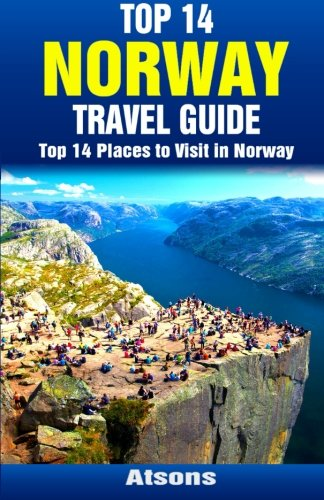

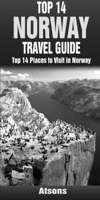

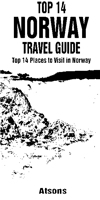

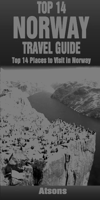

Some text has been found on the image:  ['PIACES PLACES NORWAY ATSONS TRAVEL VISIT GUIDE VISIL']


,Text,inception,SVM_inception
Top 1,Travel,Travel,Travel
Top 2,Sports & Outdoors,Sports & Outdoors,Sports & Outdoors
Top 3,History,Politics & Social Sciences,Politics & Social Sciences


(                    Text                   inception  \
 Top 1             Travel                      Travel   
 Top 2  Sports & Outdoors           Sports & Outdoors   
 Top 3            History  Politics & Social Sciences   
 
                     SVM_inception  
 Top 1                      Travel  
 Top 2           Sports & Outdoors  
 Top 3  Politics & Social Sciences  ,        Text  inception  SVM_inception
 Top 1    29         29             29
 Top 2    26         26             26
 Top 3    12         19             19)

In [25]:
prediction('C:/Users/Rajasree/Code/Final-Year-Project/images/10/test/Travel/1514393980.jpg')

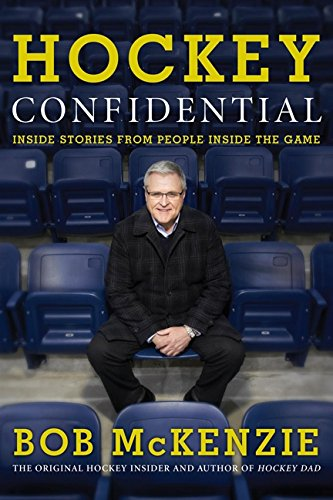

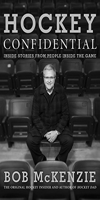

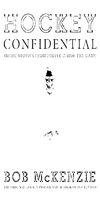

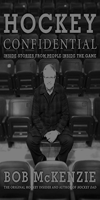

Some text has been found on the image:  ['CONFIDENTIAL HOCKEY']


,Text,inception,SVM_inception
Top 1,Sports & Outdoors,Biographies & Memoirs,Science Fiction & Fantasy
Top 2,Biographies & Memoirs,Science Fiction & Fantasy,Biographies & Memoirs
Top 3,Children's Books,Business & Money,Engineering & Transportation


,Best Predictions
Top 1,Sports & Outdoors
Top 2,Science Fiction & Fantasy
Top 3,Biographies & Memoirs


In [26]:
best_pred('C:/Users/Rajasree/Code/Final-Year-Project/images/10/test/Sports & Outdoors/0062342983.jpg')